# PROYECTO FINAL: NullStorm

## 1. Definición del problema

Actualmente, es común que los estacionamientos utilicen accesos automatizados mediante reconocimiento de matrículas. Las empresas prefieren implementar barreras automáticas con cámaras en lugar de contratar vigilantes, debido a la reducción de costos y a la mejora en la eficiencia y rapidez de acceso. Sin embargo, estos sistemas suelen ser costosos y presentan limitaciones. Además, la información recopilada suele desaprovecharse, perdiendo oportunidades para optimizar la gestión y seguridad del estacionamiento.

### 1.1. Objetivos del proyecto

El objetivo de implementar un modelo de reconocimiento de matrículas es incrementar la seguridad del estacionamiento y reducir los costos de vigilancia. No obstante, en este proyecto queremos ir más allá y complementar el modelo de computer vision con un modelo LLM capaz de acceder al historial de entradas y salidas con el fin de ofrecer información relevante al usuario para un análisis de los datos correspondientes. En definitiva, los objetivos principales de este proyecto serán:

* Desarrollar un sistema de detección de matrículas que automatice el acceso a un estacionamiento de forma eficiente.

* Reducir los costos operativos mediante un sistema rápido y preciso.

* Recopilar los datos del flujo de vehículos y almacenarlos en una base de datos.

* Poder acceder a la base de datos y hacer consultas mediante lenguaje natural.

### 1.2. Claves del proyecto

Para lograr los objetivos marcados, será necesario marcar unos criterios de éxito que permitan cumplir las expectativas.

* Preprocesar las imágenes de entrada para facilitar su posterior detección.

* Usar un modelo de computer vision para la detección y reconocimiento del vehículo

* Usar un modelo de computer vision para la detección de la matrícula.

* Reconocimiento de texto con un modelo OCR.

* Filtrar los resultados para permitir únicamente letras en mayúsculas y números.

* Obtener una respuesta rápida y precisa.

* Almacenar los datos de una forma eficiente y de fácil acceso para el LLM.

* Diseñar un LLM capaz de recibir una consulta en lenguaje natural, acceder a los datos solicitados y realizar búsquedas con lenguaje SQL.

### 1.3. Arquitectura del modelo y flujo de trabajo

1. **Captura de la imagen o vídeo en tiempo real con una cámara IP.**

Las cámaras IP se caracterizan por su capacidad de conectarse a internet y transmitir la información, lo cual es necesario para los objetivos de nuestro proyecto.

2. **Detección de vehículos y matrículas con YOLO**

Los modelos YOLO (You Only Look Once) son redes neuronales convolucionales (CNNs) diseñadas para la detección de objetos en imágenes y vídeos en tiempo real.

Por ello, se utilizarán dos modelos YOLO para llevar a cabo el presente proyecto. El primero de ellos será un modelo especializado en detección de vehículos, mientras el segundo será un modelo especializado en detección de matrículas.

Estos modelos son capaces de reconocer las cajas delimitadoras y las clases de los objetos en una sola pasada sobre la imagen, lo cual permite un rápido funcionamiento del modelo.

3. **Preprocesamiento de imágenes con OpenCV**

OpenCV es una biblioteca de código abierto para procesamiento de imágenes y visión por computadora. Se caracteriza por su capacidad para procesar imágenes mediante filtros, transformaciones y detección de bordes, facilitando el posterior reconocimiento de los caracteres de las matrículas.

De esta forma, se aplicará la conversión a escala de grises, aumento de contraste, reducción de ruido, normalización, etc.

4. **Reconocimiento de caracteres con EasyOCR**

EasyOCR es una biblioteca de OCR (Reconocimiento Óptico de Caracteres) basada en PyTorch. Esta biblioteca permite extraer texto de imágenes con gran velocidad y efectividad.

5. **Base de datos EDW con BigQuery**

Un EDW (Enterprise Data Warehouse) en BigQuery es un almacén de datos empresarial en la nube de Google Cloud, diseñado para analizar y procesar grandes volúmenes de datos.

En el presente proyecto, se diseñará una base de datos de tipo EDW con BigQuery para almacenar las matrículas y demás datos.

6. **API REST para enviar la información a la base de datos**

Una API REST (Application Programming Interface - Representational State Transfer) es un tipo de interfaz que permite la comunicación entre sistemas a través del protocolo HTTP.

Por ello, se utilizará una API REST para enviar las matrículas reconocidas por el modelo junto con los datos complementarios a la base de datos.

7. **LLM para traducir lenguaje natural a SQL**

Se diseñará una LLM mediante Prompt Engineering con la capacidad de recibir una consulta del usuario en lenguaje natural, y el modelo traducirá a lenguaje SQL adecuado a la base de datos en cuestión.

8. **Cliente SQL en Google Colab.**

Se utilizará un cliente SQL en Google Collab con la finalidad de ejecutar la consulta en la base de datos de BigQuery y recibir un dataframe con los datos solicitados.

## 2. Recolección de datos

La recolección de datos se ha llevado a cabo a través de una empresa privada que nos ha facilitado casi 3.000 fotografías de vehículos con su respectiva matrícula en la entrada de un parking. Dicha empresa nos ha concedido los derechos para utilizar dichas imágenes con fines académicos.

## 3. Preprocesamiento de datos

* Google Drive

In [ ]:
from google.colab import drive
from google.colab import auth
auth.authenticate_user()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 3.1. Limpieza del dataset

Para llevar a cabo el preprocesamiento de las imágenes, en primer lugar se eliminarán algunas imágenes no válidas para el proyecto:

* Imágenes donde la matrícula no aparece.

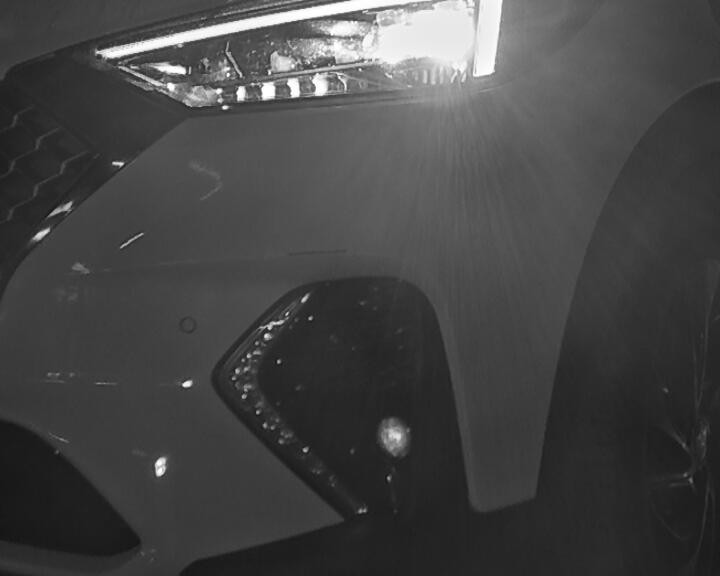

In [ ]:
imagen = Image.open("E1,CAM1,250210085024198,---,0.jpg")
display(imagen)

* Imágenes donde la placa está recortada.

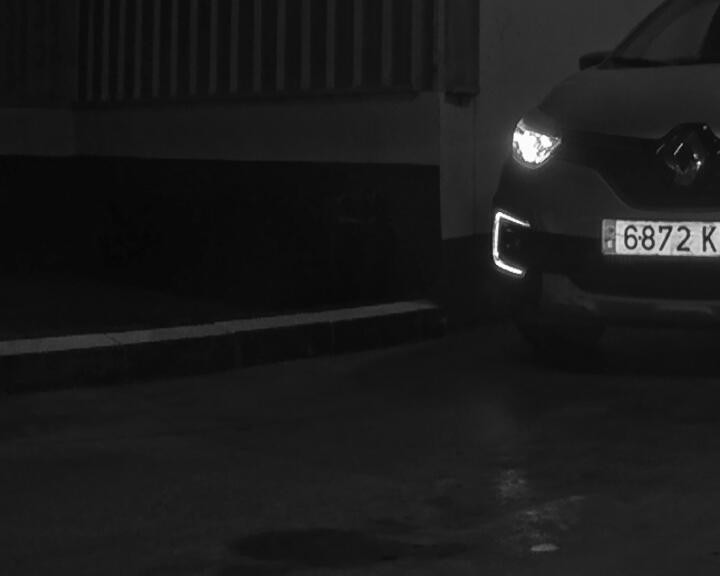

In [ ]:
imagen = Image.open("E1,CAM1,250210071308221,---,9642.jpg")
display(imagen)

* Imágenes donde la matrícula apenas se puede leer.


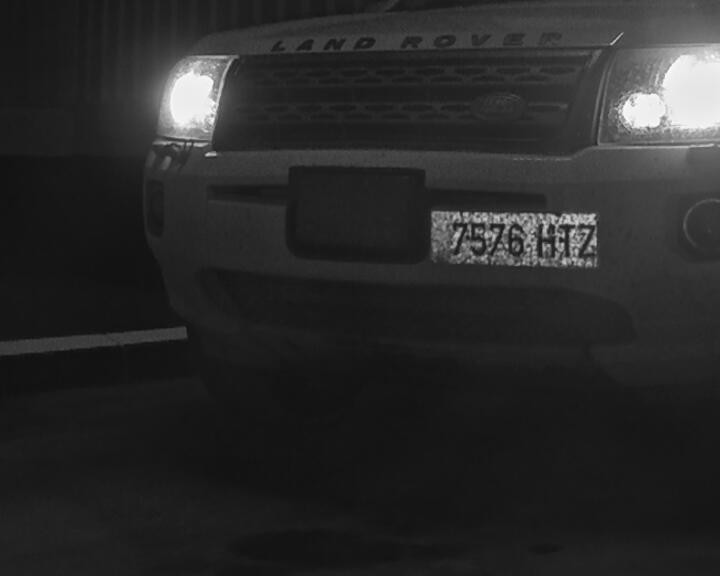

In [ ]:
imagen = Image.open("E1,CAM1,250210013813708,7576HTZ,8939.jpg")
display(imagen)

### 3.2. Mejora de las imágenes

En segundo lugar, se diseñarán diferentes funciones que lleven a cabo algunas modificaciones de las imágenes.

* Conversión a escala de grises

In [ ]:
def escala_grises(img):
    img_grises = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img_grises

* Mejora del contraste y reducción de ruido mediante ecualización del histograma, obteniendo una distribución unidorme en cuanto a la cantidad de píxeles de cada color.

In [ ]:
def mejorar_contraste(img):
    # Ecualizar el histograma para mejorar el contraste
    #ecualizada = cv2.equalizeHist(img)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_clahe = clahe.apply(img)

    return img_clahe

* Reducir el ruido con desenfoque Gaussiano

In [ ]:
def reducir_ruido(img):
  img_ruido = cv2.GaussianBlur(img, (5,5), 0)

  return img_ruido

* Detección de bordes

In [ ]:
def detect_bordes(img):
  img_bordes = cv2.Canny(img, 50, 150)

  return img_bordes

## 4. Análisis exploratorio de datos

Cargamos algunas de las imágenes del dataset obtenido para analizar los recursos de los que disponemos.

* Muchas de las imágenes son claras y de muy buena calidad.

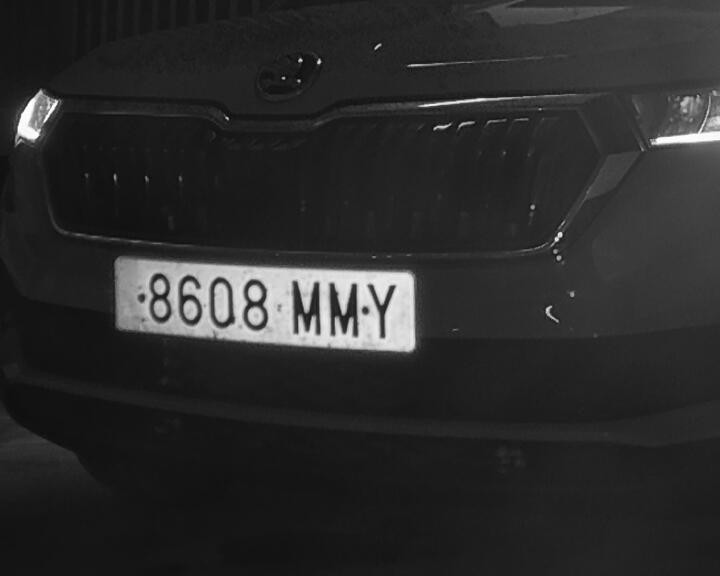

In [ ]:
imagen = Image.open("E1,CAM1,250212131853919,8608MMY,9996.jpg")
display(imagen)

* Pero también encontramos una cantidad considerable de imágenes oscuras y más difíciles detectar.

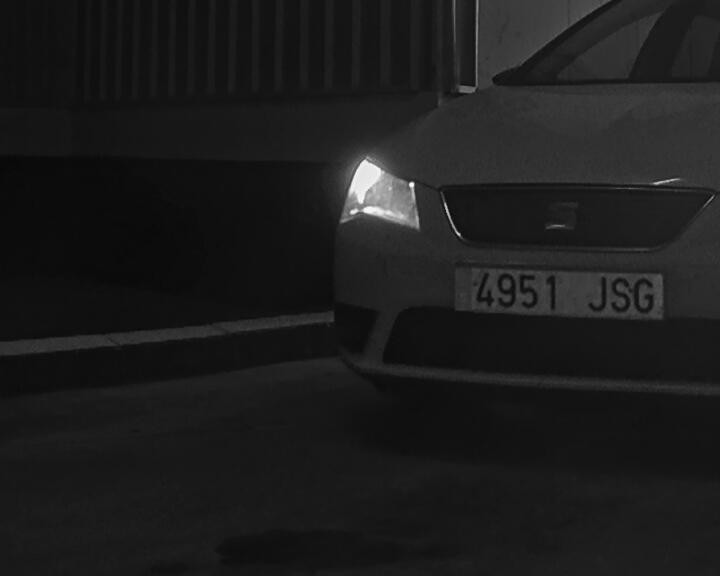

In [ ]:
imagen = Image.open("E1,CAM1,250212143605490,4951JSG,9999.jpg")
display(imagen)